In [400]:
import numpy as np
import matplotlib.pyplot as plt
import random 

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from torch.utils.tensorboard import SummaryWriter






In [401]:
def create_curve(freq, ampl, freq_noise, ampl_noise, window_size):
    freq = random.gauss(freq, freq_noise) #add noise to frequency
    ampl = random.gauss(ampl, ampl_noise) #add noise to amplitude
    time = np.linspace(0, 10*np.pi, window_size)
    x = ampl*np.cos(freq*time)
    noise = np.random.normal(random.uniform(-1,0), random.uniform(0,1), window_size)
    x+=noise
    x = np.expand_dims(x, axis = 0) #expand to get 2d array (features, window length)
    x = np.expand_dims(x, axis = 0) #expand to get 3d array to store 2d elements
    #print(f"freq: {freq}, ampl:{ampl}")
    #fig1 = plt.figure()
    #plt.plot(time, x[0,0,:])
    #plt.show()
    #fig1.savefig(f'CLASS:{CLASS}, iteration: {it}')
    
    return x

def create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size):
   
    X_data_class_1_domain_1 = np.empty((0,1,window_size))
    X_data_class_2_domain_1 = np.empty((0,1,window_size))
    X_data_class_1_domain_2 = np.empty((0,1,window_size))
    X_data_class_2_domain_2 = np.empty((0,1,window_size))
    
    for i in range(n):
        X_data_class_1_domain_1 = np.append(X_data_class_1_domain_1, create_curve(frequencies[0], amplitudes[0], freq_noise, ampl_noise, window_size), axis = 0) 
        X_data_class_2_domain_1 = np.append(X_data_class_2_domain_1, create_curve(frequencies[1], amplitudes[1], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_1_domain_2 = np.append(X_data_class_1_domain_2, create_curve(frequencies[2], amplitudes[2], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_2_domain_2 = np.append(X_data_class_2_domain_2, create_curve(frequencies[3], amplitudes[3], freq_noise, ampl_noise, window_size), axis = 0)
        
        #print(i)
        #print((X_data_class_1_domain_1))
        
    n_samples = np.shape(X_data_class_2_domain_1)[0]*2  
    
    y_data_class_1_domain_1 = np.asarray([0]*np.shape(X_data_class_1_domain_1)[0])
    y_data_class_2_domain_1 = np.asarray([1]*np.shape(X_data_class_2_domain_1)[0])
    y_data_class_1_domain_2 = np.asarray([0]*np.shape(X_data_class_1_domain_2)[0])
    y_data_class_2_domain_2 = np.asarray([1]*np.shape(X_data_class_2_domain_2)[0])
    
    X_data_source = np.concatenate((X_data_class_1_domain_1, X_data_class_2_domain_1), axis = 0)
    y_data_source = np.concatenate((y_data_class_1_domain_1, y_data_class_2_domain_1), axis = 0)
    X_data_target = np.concatenate((X_data_class_1_domain_2, X_data_class_2_domain_2), axis = 0)
    y_data_target = np.concatenate((y_data_class_1_domain_2, y_data_class_2_domain_2), axis = 0)
    
    
    X_data_source = torch.from_numpy(X_data_source)
    y_data_source = torch.from_numpy(y_data_source)
    X_data_target = torch.from_numpy(X_data_target)
    y_data_target = torch.from_numpy(y_data_target)
    
    return n_samples, X_data_source, y_data_source, X_data_target, y_data_target
"""
#TEST
frequencies = [1,4,1.4,3.6]
amplitudes = [6,2,5,4]
freq_noise = 0.3
ampl_noise = 2
window_size = 1000
n_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
"""

'\n#TEST\nfrequencies = [1,4,1.4,3.6]\namplitudes = [6,2,5,4]\nfreq_noise = 0.3\nampl_noise = 2\nwindow_size = 1000\nn_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)\n'

In [402]:
class Dataset_Dummy_Source_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,1.9,3.1]#[1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, self.x_data, self.y_data, _, _ = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class Dataset_Dummy_Target_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,1.9,3.1]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, _, _, self.x_data, self.y_data = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [403]:
#dataloader

dataset_source = Dataset_Dummy_Source_Window()

# define train/val dimensions
ce_size_source = int(0.6 * len(dataset_source))
validation_size_source = int(0.2 * len(dataset_source))
mmd_size_source = int(0.2 * len(dataset_source))


ce_dataset_source, validation_dataset_source, mmd_dataset_source = torch.utils.data.random_split(dataset_source, [ce_size_source, validation_size_source, mmd_size_source])
batch_size = 64
ce_loader_source = DataLoader(dataset=ce_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_source = DataLoader(dataset=validation_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
mmd_loader_source = DataLoader(dataset=mmd_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)






dataset_target = Dataset_Dummy_Target_Window()

# define train/val dimensions
ce_size_target = int(0.6 * len(dataset_target))
validation_size_target = int(0.2 * len(dataset_target))
mmd_size_target = int(0.2 * len(dataset_target))

ce_dataset_target, validation_dataset_target, mmd_dataset_target = torch.utils.data.random_split(dataset_target, [ce_size_target, validation_size_target, mmd_size_target])
batch_size = 64
ce_loader_target = DataLoader(dataset=ce_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_target = DataLoader(dataset=validation_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
mmd_loader_target = DataLoader(dataset=mmd_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)



source_loader = {}
source_loader["ce"] = ce_loader_source
source_loader["val"] = validation_loader_source
source_loader["mmd"] = mmd_loader_target

target_loader = {}
target_loader["ce"] = ce_loader_target
target_loader["val"] = validation_loader_target
target_loader["mmd"] = mmd_loader_target

In [454]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        
        """
        formula [(W−K+2P)/S]+1.
        """
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=100, stride=1)#input: 1000
        self.conv2 = nn.Conv1d(64,32,kernel_size=10, stride = 1, padding=1)#input: [(1000-100+2*0)/1]+1 = 901
        self.batch1 =nn.BatchNorm1d(32)#input: [(901-10+2*1)/1]+1 = 894
        self.conv3 = nn.Conv1d(32,32,kernel_size=5, stride = 1, padding=1) #input:894
        self.batch2 =nn.BatchNorm1d(32)#input: [(894-5+2*1)/1]+1 = 892
        #self.fc1 = nn.Linear(32*892, output_size)

    def forward(self, x):
        x = F.selu(self.conv1(x)) #conv1
        x = self.conv2(x) #conv2
        x = F.selu(self.batch1(x)) #batch1
        x = self.conv3(x) #conv3
        x = F.selu(self.batch2(x)) #batch2
        x = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        #x = self.fc1(x) #linear1
        output = x
        
        return output

In [455]:
input_size = 1
input_fc_size = 32*892 #25*40 
hidden_fc_size_1 = 100
hidden_fc_size_2 = 3
output_size = 2


classifier_layer_1 = nn.Linear(input_fc_size, hidden_fc_size_1)
classifier_layer_2 = nn.Linear(hidden_fc_size_1, hidden_fc_size_2)
classifier_layer_3 = nn.Linear(hidden_fc_size_2, output_size)



model = CNN(input_size, output_size)


print(model)

print(classifier_layer_1)

print(classifier_layer_2)

print(classifier_layer_3)

CNN(
  (conv1): Conv1d(1, 64, kernel_size=(100,), stride=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(10,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Linear(in_features=28544, out_features=100, bias=True)
Linear(in_features=100, out_features=3, bias=True)
Linear(in_features=3, out_features=2, bias=True)


In [456]:
#from mmd_loss import MMD_loss
class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [457]:
# to test 
"""
def forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, MMD_loss_flag_phase, GAMMA_inter_class, GAMMA_intra_class):
        
        #Feature extraction
        outputs = model(data.float())
        
        batch_size = len(labels_source)         
        
        #Classification
        x_src = classifier_layer_1(outputs[:batch_size, :])
        x_tar = classifier_layer_1(outputs[batch_size:, :])
        source_out = classifier_layer_2(x_src)
        target_out = classifier_layer_2(x_tar)
        source_pred = classifier_layer_3(source_out)
        target_pred = classifier_layer_3(target_out)
        
        source_ce_loss = criterion(source_pred, labels_source)
        target_ce_loss = criterion(target_pred, labels_target)
        
        # MMD loss
        #mmd_loss = rbf_mmd2(source_out, target_out, SIGMA)
        mmd_loss_1 = MMD_loss.forward(x_src, x_tar)
        mmd_loss_2 = MMD_loss.forward(source_out, target_out)
        mmd_loss = mmd_loss_1 + mmd_loss_2
        
        if MMD_loss_flag_phase == True:
            loss = source_ce_loss + target_ce_loss# + 2.5 * mmd_loss
        else:
        #total loss
            loss = source_ce_loss# + 2.5 * mmd_loss
    
        #collect information about labels, predictions to calculate accuracy
        n_correct_source = 0
        n_correct_target = 0
        n_samples_source = 0
        n_samples_target = 0
        
        # list of classified latent space features in FC1
        class_0_source_out = torch.empty((0,source_out.size()[1]))
        class_1_source_out = torch.empty((0,source_out.size()[1]))
        class_0_target_out = torch.empty((0,target_out.size()[1]))
        class_1_target_out = torch.empty((0,target_out.size()[1]))
        
        #SOURCE iteration through batch
        for i in range(len(labels_source)):
            
            #get label and prediction
            label_source = labels_source[i]
            output_source = torch.argmax(source_pred[i])
            if label_source == output_source: #correct prediction
                n_correct_source+=1
            n_samples_source+=1
            
            #sort x_src and source_out depending on their classes
            if label_source == 0:
                class_0_source_out = torch.cat((class_0_source_out, torch.unsqueeze(source_out[i,:],0)),0)
            elif label_source == 1:
                class_1_source_out = torch.cat((class_1_source_out, torch.unsqueeze(source_out[i,:],0)), 0)
                
        acc_total_source = 100.0 * n_correct_source / n_samples_source #source accuracy
            
            
            
        #TARGET iteration through batch
        for i in range(len(labels_target)):
            
            #check correct prediction
            label_target = labels_target[i]
            output_target = torch.argmax(target_pred[i])#correct prediction
            if label_target == output_target:
                n_correct_target+=1
            n_samples_target+=1
            
            #sort x_tar and target_out depending on their classes
            if label_target == 0:
                class_0_target_out = torch.cat((class_0_target_out, torch.unsqueeze(target_out[i,:],0)),0)
            elif label_target == 1:
                class_1_target_out = torch.cat((class_1_target_out, torch.unsqueeze(target_out[i,:], 0)), 0)
        
        acc_total_target = 100.0 * n_correct_target / n_samples_target #target accuracy
    
        
        return loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out
"""

'\ndef forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, MMD_loss_flag_phase, GAMMA_inter_class, GAMMA_intra_class):\n        \n        #Feature extraction\n        outputs = model(data.float())\n        \n        batch_size = len(labels_source)         \n        \n        #Classification\n        x_src = classifier_layer_1(outputs[:batch_size, :])\n        x_tar = classifier_layer_1(outputs[batch_size:, :])\n        source_out = classifier_layer_2(x_src)\n        target_out = classifier_layer_2(x_tar)\n        source_pred = classifier_layer_3(source_out)\n        target_pred = classifier_layer_3(target_out)\n        \n        source_ce_loss = criterion(source_pred, labels_source)\n        target_ce_loss = criterion(target_pred, labels_target)\n        \n        # MMD loss\n        #mmd_loss = rbf_mmd2(source_out, target_out, SIGMA)\n        mmd_loss_1 = MMD_loss.forward(x_src, x_tar)\n        mmd_loss_2 

In [458]:

def forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, MMD_loss_flag_phase, GAMMA_inter_class, GAMMA_intra_class):
        
        #Feature extraction
        outputs = model(data.float())
        
        batch_size = len(labels_source)         
        
        #Classification
        x_src = classifier_layer_1(outputs[:batch_size, :])
        x_tar = classifier_layer_1(outputs[batch_size:, :])
        source_out = classifier_layer_2(x_src)
        target_out = classifier_layer_2(x_tar)
        source_pred = classifier_layer_3(source_out)
        target_pred = classifier_layer_3(target_out)
        
        #CE loss
        source_ce_loss = criterion(source_pred, labels_source)
        target_ce_loss = criterion(target_pred, labels_target)

        #collect information about labels, predictions to calculate accuracy
        n_correct_source = 0
        n_correct_target = 0
        n_samples_source = 0
        n_samples_target = 0
        
        # list of classified latent space features in FC1
        class_0_source_out = torch.empty((0,source_out.size()[1]))
        class_1_source_out = torch.empty((0,source_out.size()[1]))
        class_0_target_out = torch.empty((0,target_out.size()[1]))
        class_1_target_out = torch.empty((0,target_out.size()[1]))
        
        # list of classified latent space features in FC2
        class_0_source_x = torch.empty((0,x_src.size()[1]))
        class_1_source_x = torch.empty((0,x_src.size()[1]))
        class_0_target_x = torch.empty((0,x_tar.size()[1]))
        class_1_target_x = torch.empty((0,x_tar.size()[1]))
        
        
        #SOURCE iteration through batch
        for i in range(len(labels_source)):
            
            #get label and prediction
            label_source = labels_source[i]
            output_source = torch.argmax(source_pred[i])
            if label_source == output_source: #correct prediction
                n_correct_source+=1
            n_samples_source+=1
            
            #sort x_src and source_out depending on their classes
            if label_source == 0:
                class_0_source_out = torch.cat((class_0_source_out, torch.unsqueeze(source_out[i,:],0)),0)
                class_0_source_x = torch.cat((class_0_source_x, torch.unsqueeze(x_src[i,:],0)), 0)
            elif label_source == 1:
                class_1_source_out = torch.cat((class_1_source_out, torch.unsqueeze(source_out[i,:],0)), 0)
                class_1_source_x = torch.cat((class_1_source_x, torch.unsqueeze(x_src[i,:],0)), 0)
                
        acc_total_source = 100.0 * n_correct_source / n_samples_source #source accuracy
            
            
            
        #TARGET iteration through batch
        for i in range(len(labels_target)):
            
            #check correct prediction
            label_target = labels_target[i]
            output_target = torch.argmax(target_pred[i])#correct prediction
            if label_target == output_target:
                n_correct_target+=1
            n_samples_target+=1
            #sort x_tar and target_out depending on their classes
            if label_target == 0:
                class_0_target_out = torch.cat((class_0_target_out, torch.unsqueeze(target_out[i,:],0)),0)
                class_0_target_x = torch.cat((class_0_target_x, torch.unsqueeze(x_tar[i,:],0)), 0)
            elif label_target == 1:
                class_1_target_out = torch.cat((class_1_target_out, torch.unsqueeze(target_out[i,:], 0)), 0)
                class_1_target_x = torch.cat((class_1_target_x, torch.unsqueeze(x_tar[i,:], 0)), 0)
        
        acc_total_target = 100.0 * n_correct_target / n_samples_target #target accuracy
        
        

        #Interclass MMD loss
        
        #get number of elements to caclulcate mmd loss
        min_0_x = min(class_0_source_x.size()[0], class_0_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_1_target_x.size()[0])
        min_0_out = min(class_0_source_out.size()[0], class_0_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_1_target_out.size()[0])

        mmd_x_class_0_0 = MMD_loss.forward(class_0_source_x[:min_0_x,:],class_0_target_x[:min_0_x,:])
        mmd_x_class_1_1 = MMD_loss.forward(class_1_source_x[:min_1_x,:], class_1_target_x[:min_1_x,:])
        mmd_out_class_0_0 = MMD_loss.forward(class_0_source_out[:min_0_out,:], class_0_target_out[:min_0_out,:])
        mmd_out_class_1_1 = MMD_loss.forward(class_1_source_out[:min_1_out,:], class_1_target_out[:min_1_out,:])
        mmd_loss_inter_class = mmd_x_class_0_0 + mmd_x_class_1_1 + mmd_out_class_0_0 + mmd_out_class_1_1

        #Intraclass MMD loss
        
        #get number of elements to caclulcate mmd loss
        min_0_x = min(class_0_source_x.size()[0], class_1_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_0_target_x.size()[0])
        min_0_out = min(class_0_source_out.size()[0], class_1_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_0_target_out.size()[0])

        mmd_x_class_0_1= MMD_loss.forward(class_0_source_x[:min_0_x,:], class_1_target_x[:min_0_x,:])
        mmd_x_class_1_0 = MMD_loss.forward(class_1_source_x[:min_1_x,:], class_0_target_x[:min_1_x,:])
        mmd_out_class_0_1 = MMD_loss.forward(class_0_source_out[:min_0_out,:], class_1_target_out[:min_0_out,:])
        mmd_out_class_1_0 = MMD_loss.forward(class_1_source_out[:min_1_out,:], class_0_target_out[:min_1_out,:])
        mmd_loss_intra_class = mmd_x_class_0_1 + mmd_x_class_1_0 + mmd_out_class_0_1 + mmd_out_class_1_0
        
        
        #total mmd loss
        mmd_loss = GAMMA_inter_class * mmd_loss_inter_class - GAMMA_intra_class * mmd_loss_intra_class
        
        if MMD_loss_flag_phase == True:
            loss = source_ce_loss + mmd_loss
        else:
            loss = source_ce_loss
        
        return loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out
    
    
    


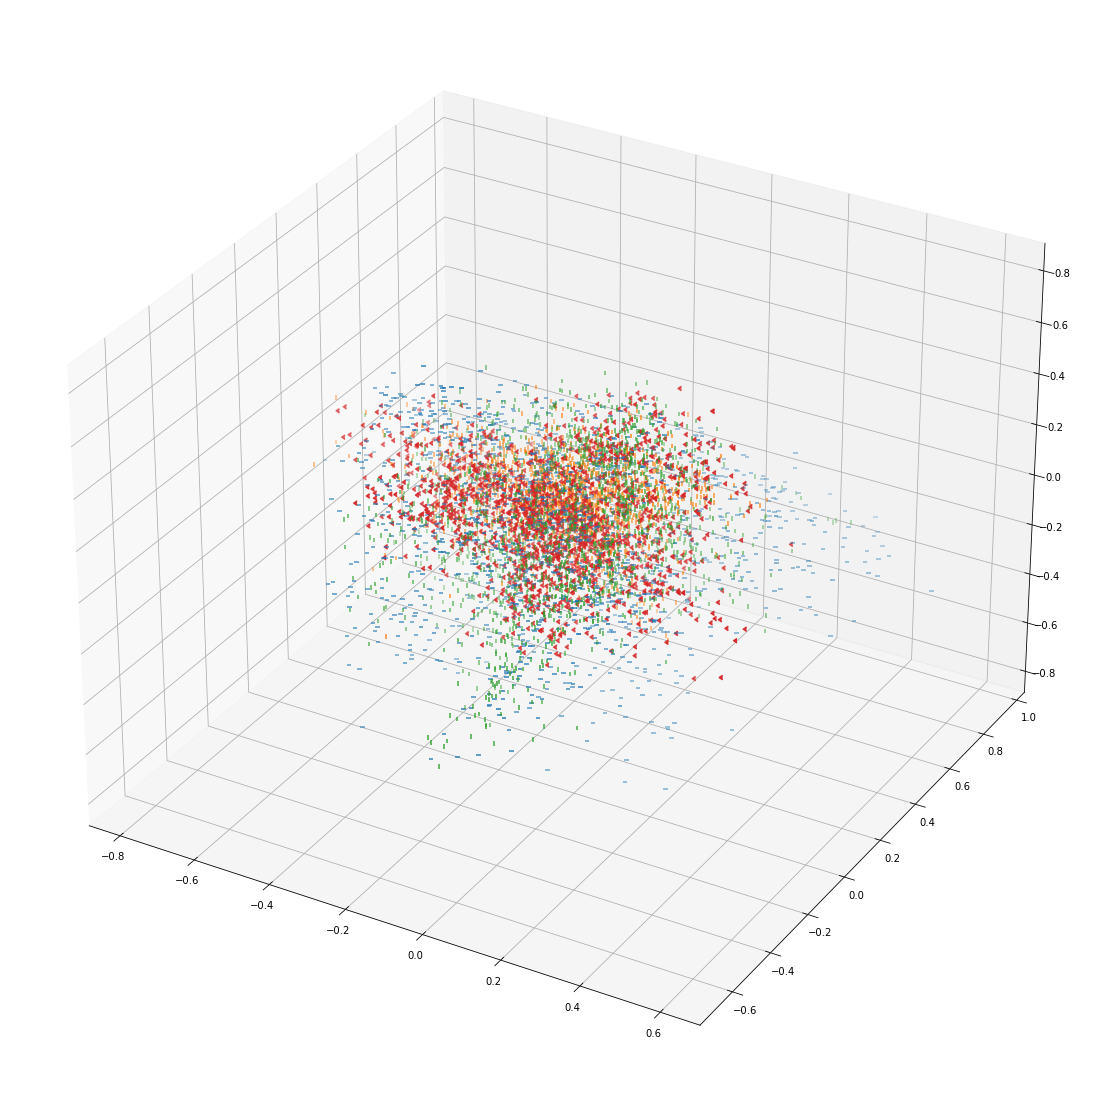

Epoch 1/10 successfull
Epoch 2/10 successfull


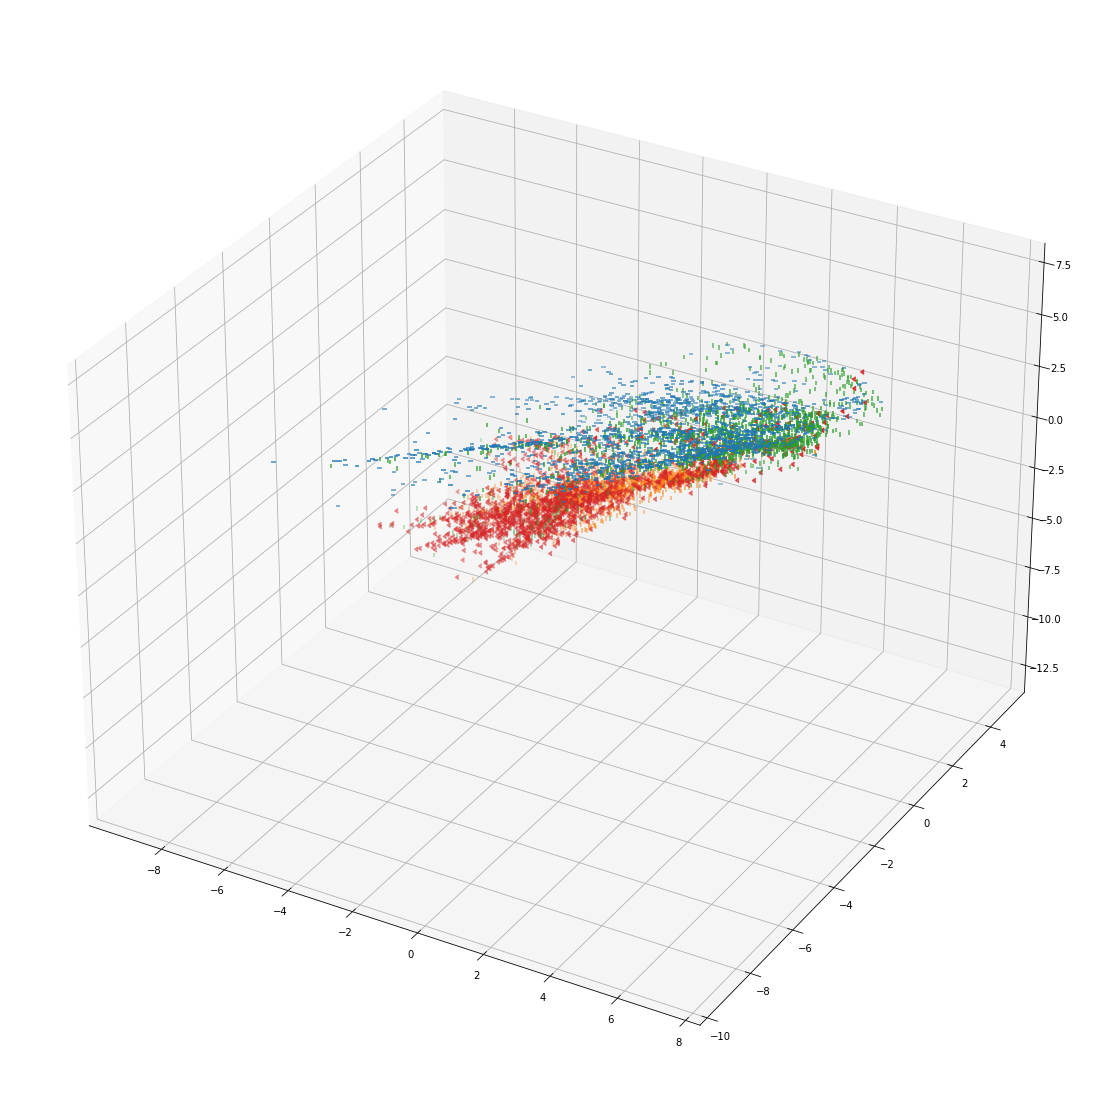

Epoch 3/10 successfull
Epoch 4/10 successfull


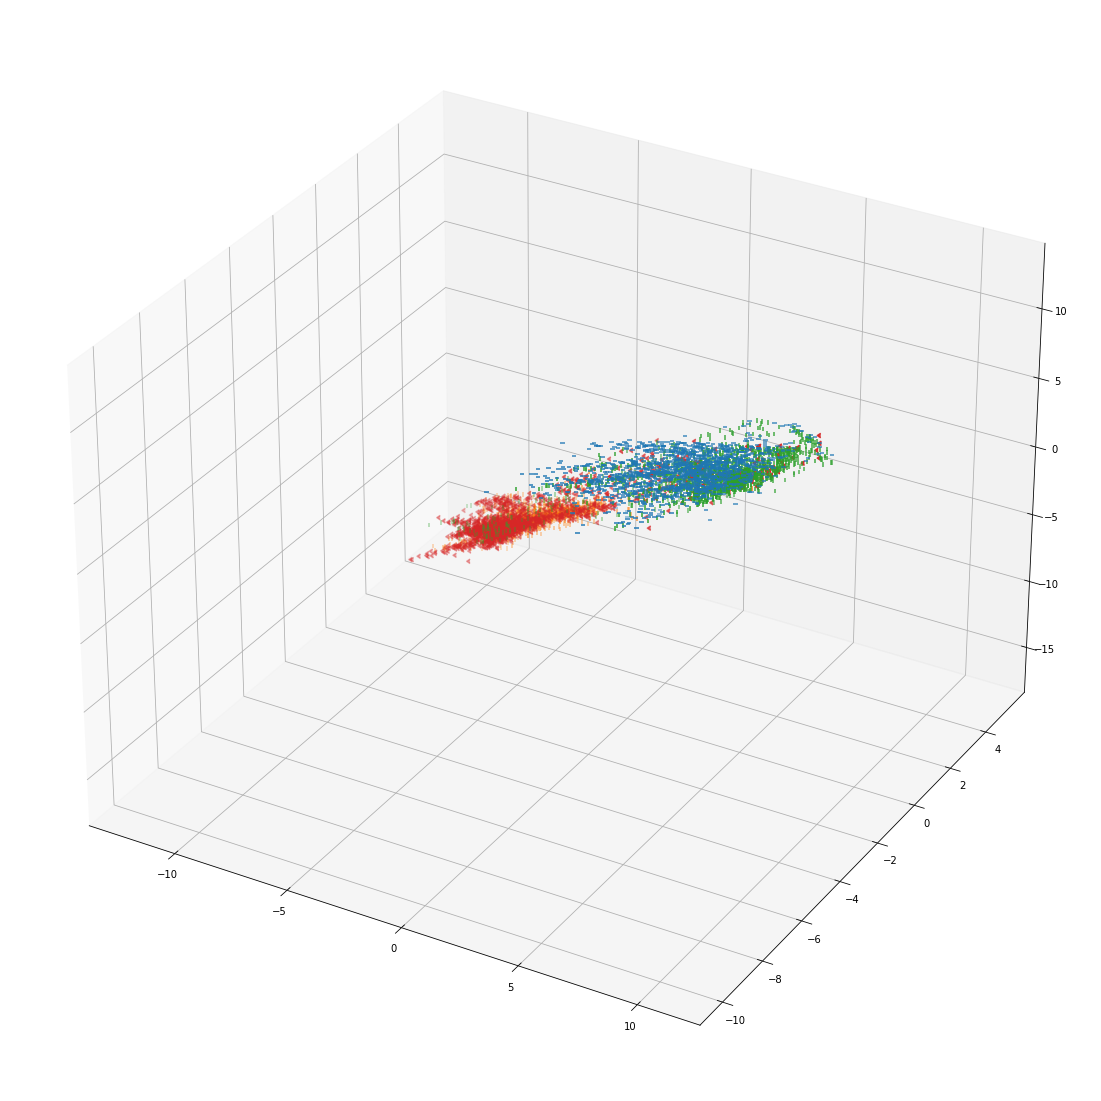

Epoch 5/10 successfull
Epoch 6/10 successfull


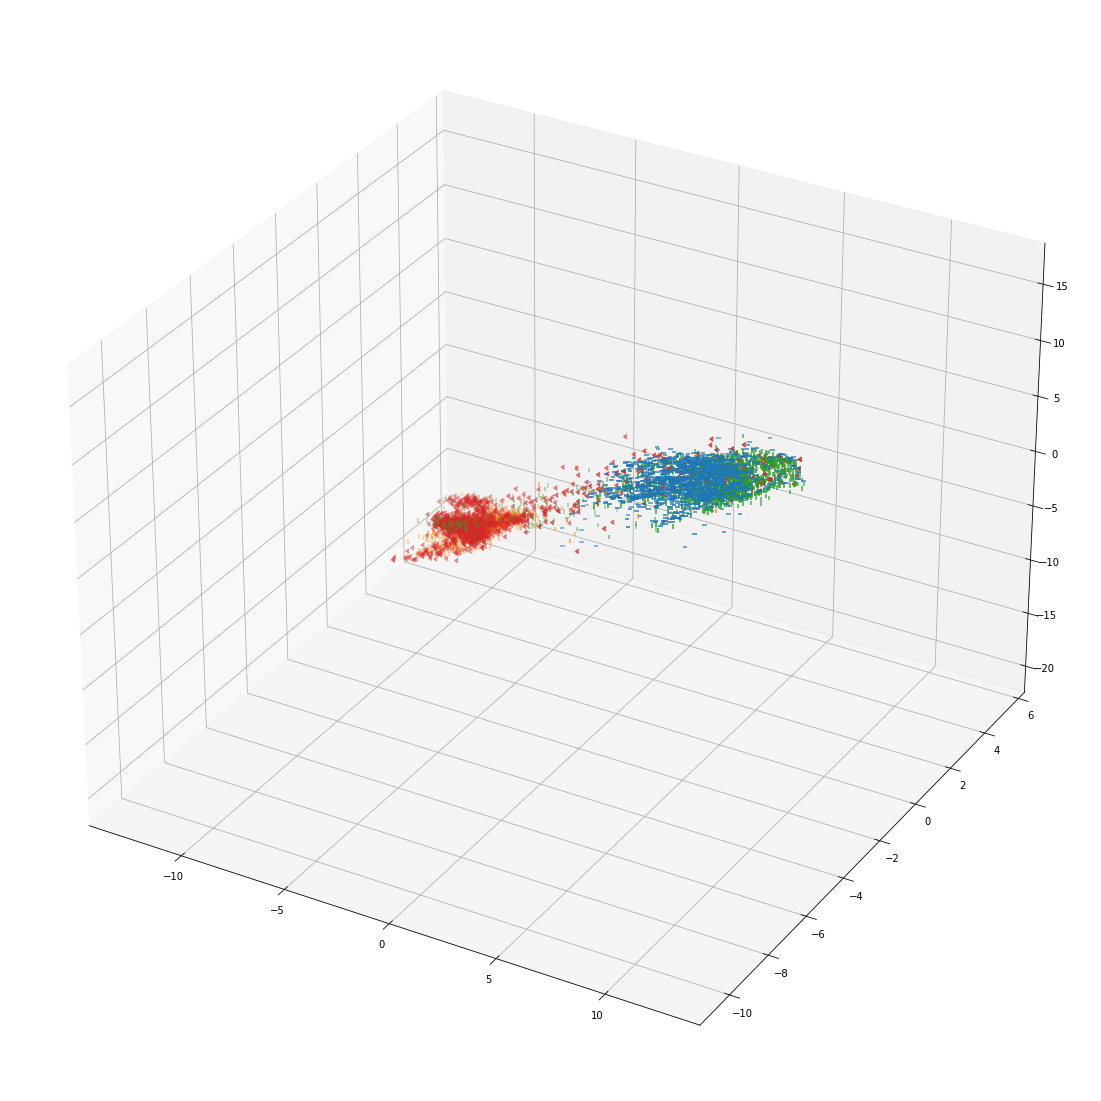

Epoch 7/10 successfull
Epoch 8/10 successfull
Epoch 9/10 successfull
Epoch 10/10 successfull


In [459]:
writer_graph = SummaryWriter('runs/Dataloader2/graph')
writer_source_val = SummaryWriter('runs/Dataloader2/source_val')
writer_source_mmd = SummaryWriter('runs/Dataloader2/source_mmd')
writer_source_ce = SummaryWriter('runs/Dataloader2/source_ce')
writer_target_val = SummaryWriter('runs/Dataloader2/target_val')
writer_target_mmd = SummaryWriter('runs/Dataloader2/target_mmd')
writer_target_ce = SummaryWriter('runs/Dataloader2/target_ce')

writer_source = {}
writer_source["val"] = writer_source_val
writer_source["mmd"] = writer_source_mmd
writer_source["ce"] = writer_source_ce

writer_target = {}
writer_target["val"] = writer_target_val
writer_target["mmd"] = writer_target_mmd
writer_target["ce"] = writer_target_ce


#define training params
num_epochs = 10
learning_rate = 0.1 #0.008
GAMMA_inter_class = 10
GAMMA_intra_class = 10
SIGMA = torch.tensor([2,4,8])  # default 1

#define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
MMD_loss = MMD_loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#training iterations
phases = ["val", "mmd", "ce"]

#mmd_loss_flag
MMD_loss_flag = {}
MMD_loss_flag["val"] = True
MMD_loss_flag["mmd"] = True
MMD_loss_flag["ce"] = False


#init train data for each batch
loss_collected = 0
source_ce_loss_collected = 0
target_ce_loss_collected = 0
mmd_loss_collected = 0
acc_total_source_collected = 0
acc_total_target_collected = 0

#plot lists
mmd_loss_list = {}
mmd_loss_list['val']=[]
mmd_loss_list['mmd']=[]
mmd_loss_list['ce'] = []

ce_loss_list_source = {}
ce_loss_list_source['val']=[]
ce_loss_list_source['mmd']=[]
ce_loss_list_source['ce'] = []

ce_loss_list_target = {}
ce_loss_list_target['val']=[]
ce_loss_list_target['mmd']=[]
ce_loss_list_target['ce'] = []

accuracy_list_source = {}
accuracy_list_source['val']=[]
accuracy_list_source['mmd']=[]
accuracy_list_source['ce'] = []

accuracy_list_target = {}
accuracy_list_target['val']=[]
accuracy_list_target['mmd']=[]
accuracy_list_target['ce'] = []

# Train and Validate the model
for epoch in range(num_epochs):
    #plot mmd
    class_0_source_out_collect = torch.empty((0,3))
    class_1_source_out_collect = torch.empty((0,3))
    class_0_target_out_collect = torch.empty((0,3))
    class_1_target_out_collect = torch.empty((0,3))

    
    for phase in phases:
        iter_loader_source = iter(source_loader[phase])
        iter_loader_target = iter(target_loader[phase])
        for i in range(len(iter_loader_source)):
            
            ########Forward pass########
            data_source, labels_source = iter_loader_source.next() #batch_size number of windows and labels from source domain
            data_target, labels_target = iter_loader_target.next() #batch_size number of windows from target domain
            data = torch.cat((data_source, data_target), dim=0) #concat the windows to 2*batch_size number of windows
            
            
            if phase == "val":
                
                #no training
                model.train(False)
                classifier_layer_1.train(False)
                classifier_layer_2.train(False)
                classifier_layer_3.train(False)
                
                
                with torch.no_grad():
                    _, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out = forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, MMD_loss_flag[phase], GAMMA_inter_class, GAMMA_intra_class)
                    
                    # collect latent features for plot 
                    class_0_source_out_collect = torch.cat((class_0_source_out_collect, class_0_source_out), 0)
                    class_1_source_out_collect = torch.cat((class_1_source_out_collect, class_1_source_out), 0)
                    class_0_target_out_collect = torch.cat((class_0_target_out_collect, class_0_target_out), 0)
                    class_1_target_out_collect = torch.cat((class_1_target_out_collect, class_1_target_out), 0)
                    
                    
            
            elif phase == "ce" or "mmd":
                
                #training
                model.train(True)
                classifier_layer_1.train(True)
                classifier_layer_2.train(True)
                classifier_layer_3.train(True)
                
                
                #if phase == "ce":
                #    model.train(False)
                #    classifier_layer_1.train(False)
                #    classifier_layer_2.train(False)
                
                ########Forward pass########
                loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, MMD_loss_flag[phase], GAMMA_inter_class, GAMMA_intra_class)
                
                mmd_loss = mmd_loss.detach()
                source_ce_loss = source_ce_loss.detach()
                target_ce_loss = target_ce_loss.detach()
                ########Backward pass########
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # collect train data for each train phase
            mmd_loss_collected += mmd_loss
            source_ce_loss_collected += source_ce_loss
            target_ce_loss_collected += target_ce_loss
            acc_total_source_collected += acc_total_source
            acc_total_target_collected += acc_total_target
            
            
                
        #plot
        if phase == "val" and (epoch ==0 or epoch ==2 or epoch == 4 or epoch ==6):

            fig = plt.figure()
            plt.gcf().set_size_inches((20, 20)) 
            ax = fig.add_subplot(projection='3d')

            m = [1,2,3,4]
            data = [class_0_source_out_collect, class_1_source_out_collect, class_0_target_out_collect, class_1_target_out_collect]
            for i in range(4):
                ax.scatter(data[i][:,0], data[i][:,1], data[i][:,2], marker=m[i])
            
            plt.show()
            fig.savefig(f"no_mmd_epoch{epoch}")            

        
        # Normalize collected train data for each train phase
        running_mmd_loss = mmd_loss_collected / len(source_loader[phase])
        
        running_acc_source = acc_total_source_collected / len(source_loader[phase])
        running_acc_target = acc_total_target_collected / len(target_loader[phase])
        
        running_source_ce_loss = source_ce_loss_collected / len(source_loader[phase])
        running_target_ce_loss = target_ce_loss_collected / len(target_loader[phase])
        
        
        #Add train data to plot list
        accuracy_list_source[phase].append(running_acc_source)
        accuracy_list_target[phase].append(running_acc_target)
        
        ce_loss_list_source[phase].append(running_source_ce_loss)
        ce_loss_list_target[phase].append(running_target_ce_loss)
        
        mmd_loss_list[phase].append(running_mmd_loss)


        #Add train data to tensorflow list
        writer_source[phase].add_scalar(f'accuracy', running_acc_source, epoch)
        writer_target[phase].add_scalar(f'accuracy', running_acc_target, epoch)
        
        writer_source[phase].add_scalar(f'ce_loss', running_source_ce_loss, epoch)
        writer_target[phase].add_scalar(f'ce_loss', running_target_ce_loss, epoch)
        
        writer_source[phase].add_scalar(f'mmd_loss', running_mmd_loss, epoch)
        

        #reset train data for each batch
        loss_collected = 0
        source_ce_loss_collected = 0
        target_ce_loss_collected = 0
        mmd_loss_collected = 0
        acc_total_source_collected = 0
        acc_total_target_collected = 0
            

    print(f"Epoch {epoch+1}/{num_epochs} successfull")




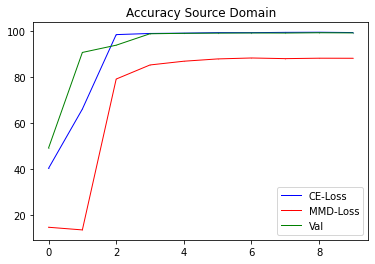

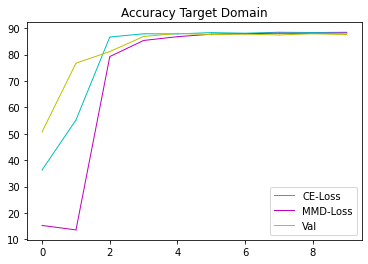

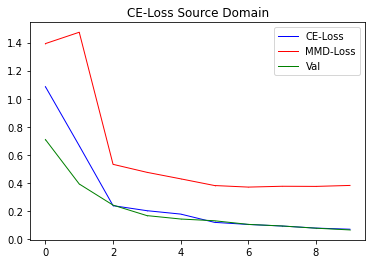

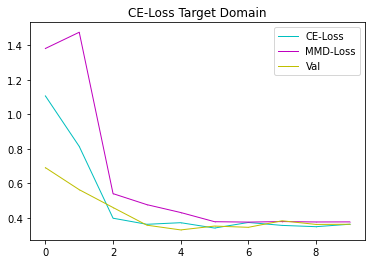

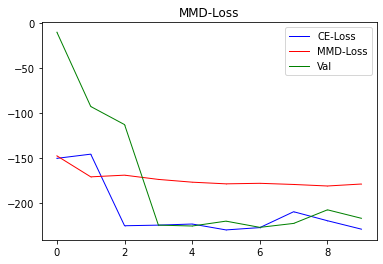

In [388]:
fig1 = plt.figure()
plt.title('Accuracy Source Domain')
plt.plot(accuracy_list_source['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('Accuracy Source Domain')

fig2 = plt.figure()
plt.title('Accuracy Target Domain')
plt.plot(accuracy_list_target['ce'], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['mmd'], 'mo-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('Accuracy Target Domain')

fig3 = plt.figure()
plt.title('CE-Loss Source Domain')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('CE_Loss Source Domain')

fig4 = plt.figure()
plt.title('CE-Loss Target Domain')
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['mmd'], 'mo-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig4.savefig('CE_Loss Target Domain')

fig5 = plt.figure()
plt.title('MMD-Loss')
plt.plot(mmd_loss_list['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig5.savefig('MMD_Loss')

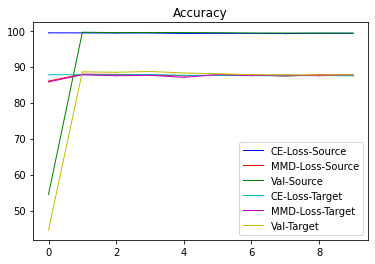

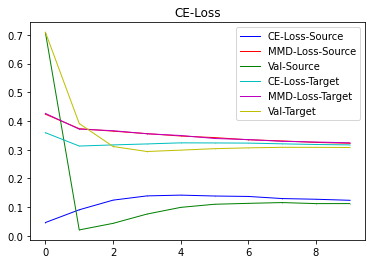

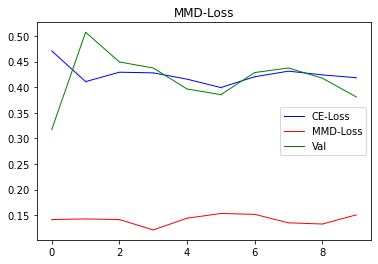

In [419]:
fig1 = plt.figure()
plt.title('Accuracy')
plt.plot(accuracy_list_source['ce'], 'bo-', label = 'CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['mmd'], 'ro-', label = 'MMD-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'], 'go-', label = 'Val-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['ce'], 'co-', label = 'CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['mmd'], 'mo-', label = 'MMD-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'], 'yo-', label = 'Val-Target', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('Accuracy')

fig2= plt.figure()
plt.title('CE-Loss')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['mmd'], 'ro-', label = 'MMD-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['mmd'], 'mo-', label = 'MMD-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val-Target', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('CE_Loss')

fig3 = plt.figure()
plt.title('MMD-Loss')
plt.plot(mmd_loss_list['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('MMD_Loss')



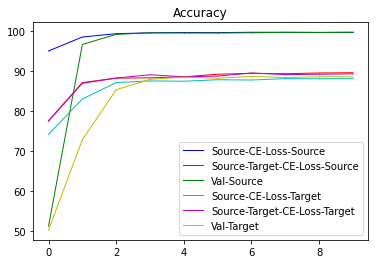

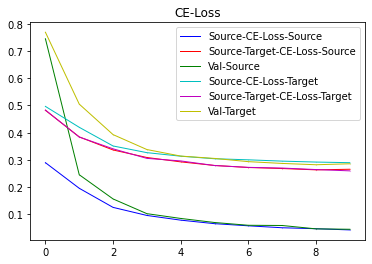

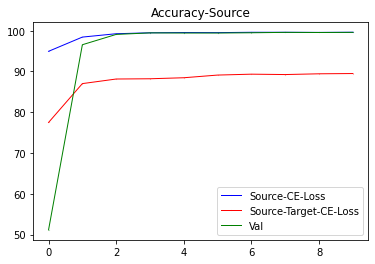

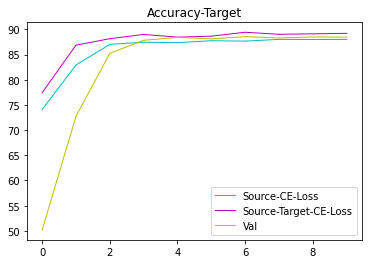

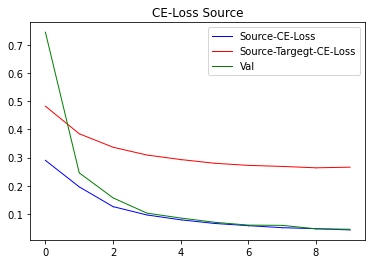

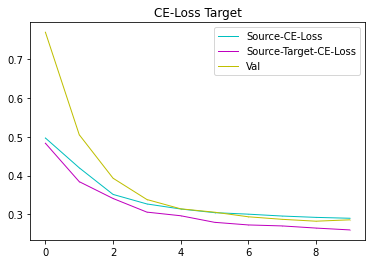

In [440]:
"""
#to test
fig1 = plt.figure()
plt.title('Accuracy')
plt.plot(accuracy_list_source['ce'], 'bo-', label = 'Source-CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['mmd'], 'ro-', label = 'Source-Target-CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'], 'go-', label = 'Val-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['ce'], 'co-', label = 'Source-CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['mmd'], 'mo-', label = 'Source-Target-CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'], 'yo-', label = 'Val-Target', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('Accuracy')

fig2= plt.figure()
plt.title('CE-Loss')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'Source-CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['mmd'], 'ro-', label = 'Source-Target-CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'Source-CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['mmd'], 'mo-', label = 'Source-Target-CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val-Target', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('CE_Loss')

#to test
fig3 = plt.figure()
plt.title('Accuracy-Source')
plt.plot(accuracy_list_source['ce'], 'bo-', label = 'Source-CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['mmd'], 'ro-', label = 'Source-Target-CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('Accuracy-Source')

#to test
fig4 = plt.figure()
plt.title('Accuracy-Target')
plt.plot(accuracy_list_target['ce'], 'co-', label = 'Source-CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['mmd'], 'mo-', label = 'Source-Target-CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig4.savefig('Accuracy-Target')

fig5= plt.figure()
plt.title('CE-Loss Source')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'Source-CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['mmd'], 'ro-', label = 'Source-Targegt-CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig5.savefig('CE_Loss Source')

fig6= plt.figure()
plt.title('CE-Loss Target')
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'Source-CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['mmd'], 'mo-', label = 'Source-Target-CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig6.savefig('CE_Loss Target')



"""

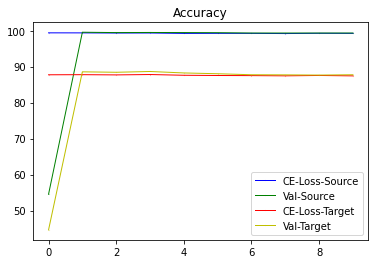

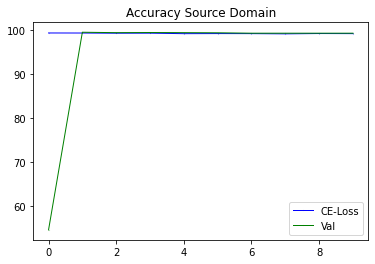

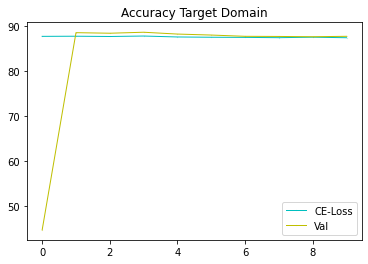

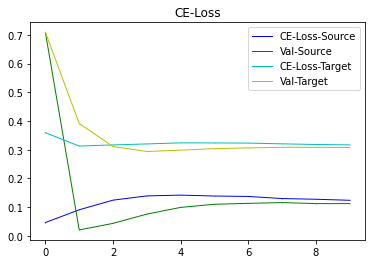

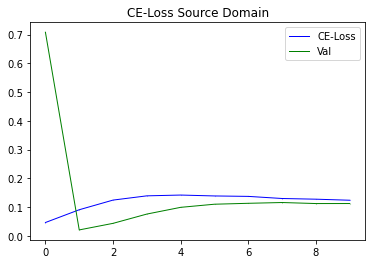

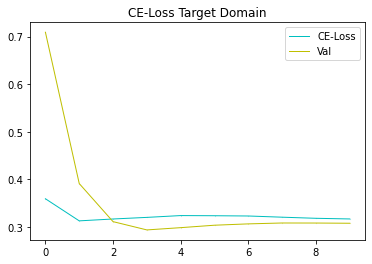

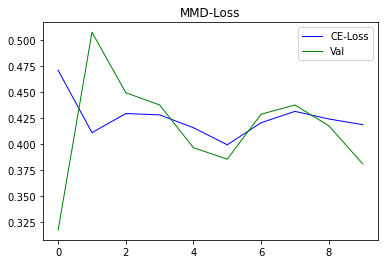

In [418]:
#to test
"""
fig1 = plt.figure()
plt.title('Accuracy')
plt.plot(accuracy_list_source['ce'], 'bo-', label = 'CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'], 'go-', label = 'Val-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['ce'], 'ro-', label = 'CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'], 'yo-', label = 'Val-Target', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('Accuracy')

fig2 = plt.figure()
plt.title('Accuracy Source Domain')
plt.plot(accuracy_list_source['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('Accuracy Source Domain')

fig3 = plt.figure()
plt.title('Accuracy Target Domain')
plt.plot(accuracy_list_target['ce'], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('Accuracy Target Domain')


fig4= plt.figure()
plt.title('CE-Loss')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val-Target', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig4.savefig('CE-Loss')

fig5= plt.figure()
plt.title('CE-Loss Source Domain')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig5.savefig('CE-Loss Source Domain')

fig6= plt.figure()
plt.title('CE-Loss Target Domain')
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig6.savefig('CE-Loss Target Domain')

fig7 = plt.figure()
plt.title('MMD-Loss')
plt.plot(mmd_loss_list['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig7.savefig('MMD-Loss')
"""


In [41]:
with torch.no_grad():
    classes = ['class_0', 'class_1']
        
    #collect information about labels, predictions
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    n_class_samples_out = [0 for i in range(2)]
        
    #iterate through bateches in test_loader
    for i, (window, labels) in enumerate(target_loader["test"]):
        #make predictions for each batch
        outputs = model(window.float())
        outputs = classifier_layer_1(outputs)
        outputs = classifier_layer_2(outputs)
        outputs = classifier_layer_3(outputs)
        #for each element in batch check if prediction is correct and collect total and correct predictions and labels
        for i in range(len(labels)):
            label = labels[i]
            output = torch.argmax(outputs[i])
            print(output)
            if label == output:
                n_correct+=1
                n_class_correct[label]+=1
                    
            n_samples+=1
            n_class_samples[label]+=1
            n_class_samples_out[output]+=1
        else:
            break
        
    #calculate total accuracy
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
        
    #calculate class accuracy
    for i in range(4):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %') 




tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
Accuracy of the network: 96.875 %
Accuracy of class_0: 94.5945945945946 %
Accuracy of class_1: 100.0 %


IndexError: list index out of range